In [36]:
import re
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liamw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Cleaning

In [37]:
# Load the data from the comments database, returns the tuple (comments, categories)
def load_data():
    # read in the comments for each video from database
    conn1 = sqlite3.connect("youtubeComments.db")
    c1 = conn1.cursor()
    c1.execute("""select c.videoID, textOriginal, categoryID
        from commentsThreads c join ytidlist y on c.videoID = y.videoID
        order by c.videoID""")
    comments = c1.fetchall()

    # using the fact that comments are ordered by videoID perform a manual group by
    # so that videos[i] contains a giant string of all comments on the video
    video_id = comments[0][0]
    video_comments = [""]
    categories = [comments[0][2]] # store category ID of each video to use as a label
    for comment in comments:
        if video_id != comment[0]:
            video_id = comment[0]
            video_comments.append("")
            categories.append(comment[2])
        video_comments[-1] += comment[1] + " "

    return video_comments, categories

In [38]:
# a function that performs preprocessing on the text, removing symbols and stopwords
punctuation_re = re.compile('[/(){}\[\]\|@,;]')
non_alphanumeric_re = re.compile('[^0-9a-z #+_]')
stopwords = set(stopwords.words('english'))
def text_prepare(text):
    text = text.lower()
    text = re.sub(punctuation_re, " ", text)
    text = re.sub(non_alphanumeric_re, "", text)

    # delete stopwords from text
    for word in stopwords:
      text = re.sub('(^|\s+)' + word + '($|\s+)', " ", text)

    # clean up whitespace
    text = text.strip()
    text = re.sub('\s+', ' ', text) # transform all multi spaces into one space
    return text

In [39]:
# convert a scikitlearn sparse matrix to a tensorflow sparse tensor
def convert_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.sparse.SparseTensor(indices, coo.data, coo.shape))

In [40]:
# create bag of words dataset using the tfidf method
def create_dataset():
    # load data and perform pre-processing
    X, y = load_data()
    comments = list(map(text_prepare, X))
    y = pd.get_dummies(y) # convert y to one hot vectors

    # split into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    # create and train tfidf vectorizer
    tfidf_vectorizer = TfidfVectorizer(min_df = 2/len(comments),
                                       max_df = 0.9,
                                       ngram_range = (1, 2),
                                       token_pattern = '(\S+)')
    tfidf_vectorizer.fit(X_train) # important to only fit on X_train to avoid data leakage

    # apply the vectorizer and then transform the sparse matrix returned to a tensorflow sparse tensor
    # so that tensorflow models can be used
    X_train = convert_to_sparse_tensor(tfidf_vectorizer.transform(X_train))
    X_test = convert_to_sparse_tensor(tfidf_vectorizer.transform(X_test))
    return X_train, X_test, y_train, y_test, tfidf_vectorizer.vocabulary_

In [41]:
X_train, X_test, y_train, y_test, vocabulary = create_dataset()
# convert labels to be np array to work with tensorflow
y_train = np.asarray(y_train) 
y_test = np.asarray(y_test)

# Model Creation

In [42]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

In [43]:
# create a function to plot performance over a models training process
def plot_training(history, y_min, y_max, title="model training"):
    plt.plot(history.history["categorical_accuracy"], label="training")
    plt.plot(history.history["val_categorical_accuracy"], label="validation")
    plt.xticks(range(0, len(history.history["categorical_accuracy"]) + 5, 5))
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Categorical accuracy")
    plt.legend()
    plt.gca().set_ylim([y_min, y_max])
    plt.show()

### Simple bag of words model

In [31]:
# build model
X = Input(shape=(X_train.shape[1], ))
dense1 = Dense(100, activation = "relu")(X)
dense2 = Dense(y_train.shape[1], activation = "softmax")(dense1)
nn = Model(inputs = X, outputs = dense3)
nn.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 218757)]          0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               21875800  
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
Total params: 21,886,910
Trainable params: 21,886,910
Non-trainable params: 0
_________________________________________________________________


In [32]:
# train model
nn.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['CategoricalAccuracy'])
history = nn.fit(X_train, y_train,
                 batch_size = 32, epochs = 30,
                 validation_data = (X_test, y_test))

Epoch 1/30
23/23 [==============================] - 2s 83ms/step - loss: 2.2476 - categorical_accuracy: 0.3329 - val_loss: 2.1353 - val_categorical_accuracy: 0.5000
Epoch 2/30
23/23 [==============================] - 2s 88ms/step - loss: 1.6142 - categorical_accuracy: 0.9045 - val_loss: 1.7550 - val_categorical_accuracy: 0.5618
Epoch 3/30
23/23 [==============================] - 2s 84ms/step - loss: 0.6483 - categorical_accuracy: 0.9846 - val_loss: 1.3829 - val_categorical_accuracy: 0.5899
Epoch 4/30
23/23 [==============================] - 2s 79ms/step - loss: 0.1464 - categorical_accuracy: 0.9986 - val_loss: 1.2153 - val_categorical_accuracy: 0.6404
Epoch 5/30
23/23 [==============================] - 2s 88ms/step - loss: 0.0461 - categorical_accuracy: 1.0000 - val_loss: 1.1247 - val_categorical_accuracy: 0.7079
Epoch 6/30
23/23 [==============================] - 2s 93ms/step - loss: 0.0223 - categorical_accuracy: 1.0000 - val_loss: 1.0839 - val_categorical_accuracy: 0.7022
Epoch 7/30

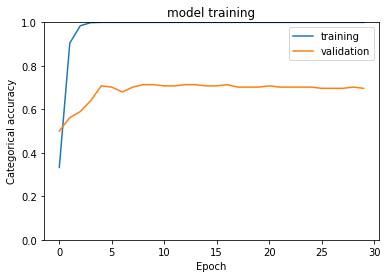

In [33]:
plot_training(history, 0, 1)

### LSTM model

In [89]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, LSTM, Embedding

having the same sequence length is necessary for batching, we first examine the number of words in the comment section of each video

In [59]:
# first get the data, we need the normal words format not the bag of words array
X, y = load_data()
comments = list(map(text_prepare, X))
y = pd.get_dummies(y) # convert y to one hot vectors

In [78]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

(array([223., 317.,  99.,  32.,  20.,  13.,   5.,   0.,   1.,   2.]),
 array([  323. ,  3446.4,  6569.8,  9693.2, 12816.6, 15940. , 19063.4,
        22186.8, 25310.2, 28433.6, 31557. ]),
 <a list of 10 Patch objects>)

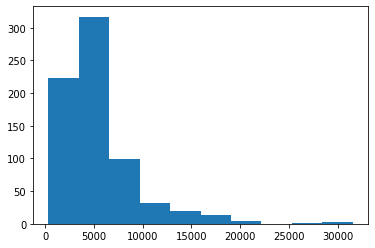

In [51]:
words_per_video = list(map(lambda x: len(x.split(" ")), X_train))
plt.hist(words_per_video)

In [52]:
np.mean(words_per_video)

5532.077247191011

Now we need to create our dataset, 5000 words is too much for an LSTM so I'll first try 400

In [80]:
# create a function that creates the LSTM dataset
def lstm_dataset(X_train, X_test, sequence_length, max_words):
    tokenizer = Tokenizer(num_words = max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)
    X_train = tokenize_text(X_train, tokenizer, sequence_length)
    X_test = tokenize_text(X_test, tokenizer, sequence_length)
    return X_train, X_test
    
# function that tokenizes and pads text
def tokenize_text(text, tokenizer, sequence_length):
    tokens = tokenizer.texts_to_sequences(text)
    tokens = pad_sequences(tokens, maxlen=sequence_length, padding='post', truncating='post')
    return tokens

In [112]:
max_words = 100000 # this needs to be below the number of unique words in the training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_test = lstm_dataset(X_train, X_test, 5000, max_words)

In [113]:
model = tf.keras.Sequential()
model.add(Embedding(max_words, 50))
model.add(Bidirectional(LSTM(50, activation='tanh', dropout=0.5, recurrent_dropout=0.5)))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 50)          5000000   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_28 (Dense)             (None, 10)                1010      
Total params: 5,041,410
Trainable params: 5,041,410
Non-trainable params: 0
_________________________________________________________________


Unfortunately training doesn't go well, I think we need to use pretrained word2vec embeddings as we don't have enough data

In [ ]:
# train model
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['CategoricalAccuracy'])
history = model.fit(X_train, y_train,
     batch_size = 32, epochs = 30,
     validation_data = (X_test, y_test))

Epoch 1/30
23/23 [==============================] - 597s 26s/step - loss: 2.3037 - categorical_accuracy: 0.0969 - val_loss: 2.2966 - val_categorical_accuracy: 0.1404
Epoch 2/30
23/23 [==============================] - 902s 39s/step - loss: 2.2894 - categorical_accuracy: 0.1601 - val_loss: 2.2931 - val_categorical_accuracy: 0.1629
Epoch 3/30
23/23 [==============================] - 1031s 45s/step - loss: 2.2601 - categorical_accuracy: 0.2247 - val_loss: 2.2842 - val_categorical_accuracy: 0.1854
Epoch 4/30
23/23 [==============================] - 1104s 48s/step - loss: 2.1468 - categorical_accuracy: 0.2388 - val_loss: 2.2120 - val_categorical_accuracy: 0.2022
Epoch 5/30
23/23 [==============================] - 1146s 50s/step - loss: 1.9283 - categorical_accuracy: 0.3132 - val_loss: 2.1833 - val_categorical_accuracy: 0.1854
Epoch 6/30
23/23 [==============================] - 1274s 55s/step - loss: 1.7130 - categorical_accuracy: 0.3511 - val_loss: 2.2289 - val_categorical_accuracy: 0.2022
